In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("manideep1108/tusimple")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/manideep1108/tusimple/versions/5


In [4]:
import os # ['readme.md', 'clips', 'label_data_0531.json', 'seg_label', 'label_data_0313.json', 'label_data_0601.json']
directory_contains = os.listdir(path+"/TUSimple/train_set/seg_label")
print(directory_contains)

['0313-2', '0530', 'list', '0531', 'test.json', 'train_val.json', '0601', '0313-1']


In [5]:
# import required libraries/dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

# import os
import shutil

In [6]:
# create the directory for storing the new dataset
!mkdir tusimple_preprocessed
!cd tusimple_preprocessed && mkdir training
!cd tusimple_preprocessed/training && mkdir frames && mkdir lane-masks

mkdir: cannot create directory ‘tusimple_preprocessed’: File exists
mkdir: cannot create directory ‘training’: File exists
mkdir: cannot create directory ‘frames’: File exists


In [7]:
'''
In 'clips' directory, we get the 20th frame from each video clip
and copy the image/frame to a new directory of which path is assigned to the variable 'new_frames' below.
'''
clips = path + '/TUSimple/train_set/clips/'
new_frames = '/content/tusimple_preprocessed/training/frames'
# new_frames = os.path.join(path,'tusimple_preprocessed','training','frames')
# Create the necessary directories if they don't exist
# os.makedirs(new_frames, exist_ok=True)


for i in os.listdir(clips):
    for j in os.listdir(os.path.join(clips, i)):
        # get the 20th frame
        frame = os.path.join(clips, i, j, '20.jpg')
        '''
            create a new name for each frame: here the directories' names
            e.g. 'clips/0531/1492629775931278791/20.jpg' becomes  '0531_1492629775931278791.jpg'
        '''
        tmp = frame[:-7].split('/')[-2:]
        new_fn = f'{tmp[0]}_{tmp[1]}.jpg'
        new_file = os.path.join(new_frames, new_fn)
        shutil.copy(frame, new_file)
    print('Done with: ', i)

Done with:  0313-2
Done with:  0531
Done with:  0601
Done with:  0313-1


In [8]:
def generate_lane_mask(row, training_set=True):
    '''
        Generates and writes the corresponding lane masks for the given images
    '''
    # create a mask of all zeros
    mask = np.zeros((720, 1280, 3))
    h_samples = row.h_samples
    lanes = row.lanes
    raw_file = row.raw_file

    # create mask: lane: 1, non-lane: 0
    for lane in lanes:
        '''
        -2 indicates no line in the specified point, so we omit the points from lane markings list
        '''
        h_samples_updated = [y for x, y in zip(lane, h_samples) if x != -2]
        lane = [x for x in lane if x != -2]
        lane_points = np.array(list(zip(lane, h_samples_updated)))
        # add lane markings to the mask we created
        cv2.polylines(mask, [lane_points], False, (255, 255, 255), thickness=15)

        # write the lane mask to the desired directory
        if training_set:
            path = '/content/tusimple_preprocessed/training/lane-masks'
            # path + '/tusimple_preprocessed/training/lane-masks'
        else:
            path = '/content/tusimple_preprocessed/training/lane-masks'
            # path + '/tusimple_preprocessed/test/lane-masks'
        '''
            name each mask according to its image's name.
            e.g. 'clips/0531/1492629775931278791/20.jpg' becomes '0531_1492629775931278791.jpg'
        '''
        tmp = raw_file[:-7].split('/')[-2:]
        mask_fname = f'{tmp[0]}_{tmp[1]}.jpg'
        new_file = os.path.join(path, mask_fname)
        cv2.imwrite(new_file, mask)
    return mask_fname

In [9]:
# load the datasets: json files: label data files
df_0601 = pd.read_json(path + '/TUSimple/train_set/label_data_0601.json', lines=True)
df_0313 = pd.read_json(path + '/TUSimple/train_set/label_data_0313.json', lines=True)
df_0531 = pd.read_json(path + '/TUSimple/train_set/label_data_0531.json', lines=True)
df = pd.concat([df_0601, df_0313, df_0531])

In [10]:
# generate masks based on the json files above
for index, row in df.iterrows():
    # generate the lane mask for each frame
    generate_lane_mask(row)
    if index%200 == 0:
        print('Row: ', index)

Row:  0
Row:  200
Row:  400
Row:  0
Row:  200
Row:  400
Row:  600
Row:  800
Row:  1000
Row:  1200
Row:  1400
Row:  1600
Row:  1800
Row:  2000
Row:  2200
Row:  2400
Row:  2600
Row:  2800
Row:  0
Row:  200


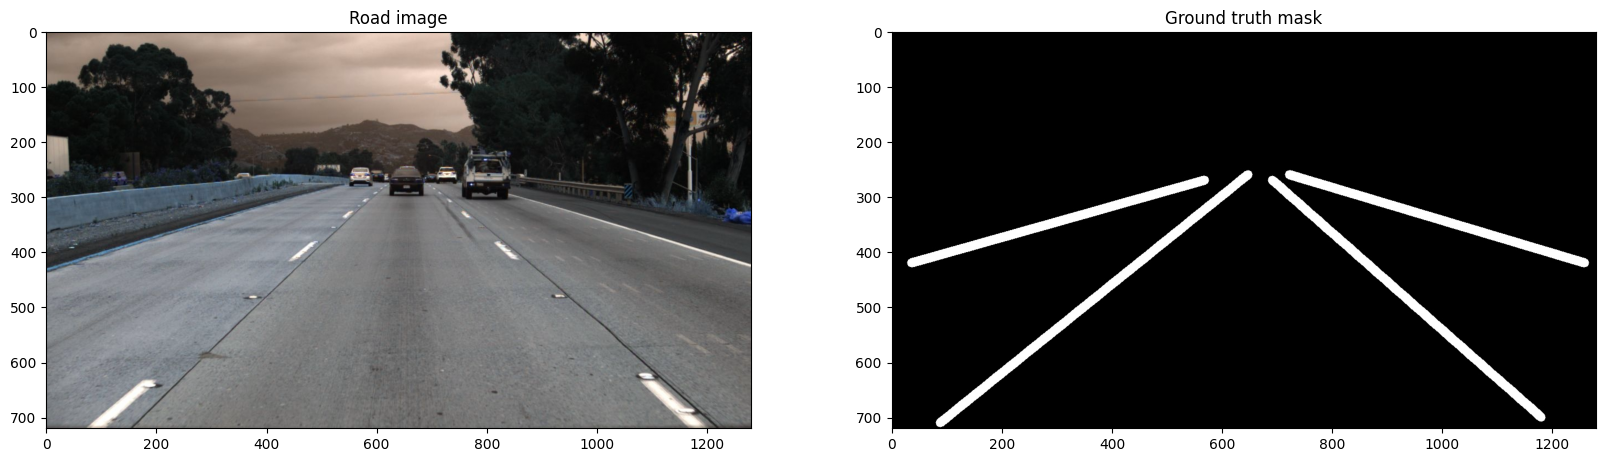

In [11]:
# visualize an example image and its corresponding lane mask
img_mask = cv2.imread('/content/tusimple_preprocessed/training/lane-masks/0601_1494453497604532231.jpg')
img_color = cv2.imread('/content/tusimple_preprocessed/training/frames/0601_1494453497604532231.jpg')

# training set
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.imshow(img_color/255.)
plt.title('Road image')

plt.subplot(1, 2, 2)
plt.imshow(img_mask/255., cmap='gray')
plt.title('Ground truth mask')

plt.show()

In [12]:
# image_path => frames & masks_path => lane_masks
# check if we have the same image-mask pairs in the training set
images_path = '/content/tusimple_preprocessed/training/frames'
masks_path = '/content/tusimple_preprocessed/training/lane-masks'
assert os.listdir(images_path) == os.listdir(masks_path)

In [3]:
# zip the training folder
!zip -r -q training.zip '/content/tusimple_preprocessed'